## Sensitivity to $\Delta z$ and $\Delta t$

This notebook compares the sensitivity to vertical resolution and time step for different schemes in the OCS-Papa case.

In the figure, each panel shows the root-mean-square (RMS) differences of the simulated temperature ($^\circ$C) using different vertical resolutions and time steps as compared to the finest resolution simulation ($\Delta t = 1$ min, $\Delta z = 1$ m).
Results with three diﬀerent vertical resolutions ($\Delta z = [1, 5, 10]$ m) and four different time steps ($\Delta t = [1, 10, 30, 60]$ min) are shown.
The gray line in each panel marks the standard deviation of the simulated temperature across all schemes with the finest resolution.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
sys.path.append(os.environ['GOTMWORK_ROOT']+'/tools', )
from gotmanalysis import GOTMOutputDataSet
%matplotlib inline

In [2]:
# list of turbulent methods
turbmethod_list = ['KPP-CVMix',
                   'KPP-ROMS',
                   'KPPLT-EFACTOR',
                   'KPPLT-ENTR',
                   'KPPLT-RWHGK',
                   'EPBL',
                   'EPBL-LT',
                   'SMC',
                   'SMCLT',
                   'K-EPSILON-SG',
                   'OSMOSIS']
legend_list = ['KPP-CVMix',
               'KPP-ROMS',
               'KPPLT-VR12',
               'KPPLT-LF17',
               'KPPLT-R16',
               'ePBL',
               'ePBL-LT',
               'SMC-KC94',
               'SMCLT-H15',
               '$k$-$\epsilon$-SG95',
               'OSMOSIS']
dzdt_list = ['VR1m_DT60s',
             'VR1m_DT600s',
             'VR1m_DT1800s',
             'VR1m_DT3600s',
             'VR5m_DT60s',
             'VR5m_DT600s',
             'VR5m_DT1800s',
             'VR5m_DT3600s',
             'VR10m_DT60s',
             'VR10m_DT600s',
             'VR10m_DT1800s',
             'VR10m_DT3600s']
l_interp = [False, False, False, False,
            True, True, True, True,
            True, True, True, True]
tm_color = ['black',
            'blue',
            'red',
            'orange',
            'purple',
            'skyblue',
            'steelblue',
            'limegreen',
            'green',
            'mediumvioletred',
            'darkgoldenrod']
dir_in = os.environ['GOTMRUN_ROOT']+'/TEST_RES_dampV_5d'
dir_out = os.environ['GOTMFIG_ROOT']+'/TEST_RES_dampV_5d'
# list of location
irow_2col = [1, 2, 0, 1, 2, 3, 3, 4, 4, 5, 5]
icol_2col = [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]
labels_2col = ['(a)', '(b)', '(f)', '(g)', '(h)', '(c)', '(i)', '(d)', '(j)','(e)','(k)']

cmap = cm.get_cmap('bone')
bcolor = cmap([0.85, 0.75, 0.65, 0.55])
# case = 'OSMOSIS_spring'
# ymax = 0.4
# case = 'OSMOSIS_winter'
# ymax = 0.6
case = 'OCSPapa_20120321-20130320'
ymax = 1.5
var = 'temp'

nm = len(turbmethod_list)
nzt = len(dzdt_list)
ndt = 4
dz = np.zeros(nzt)
dt = np.zeros(nzt)
dz_str, dt_str = dzdt_list[0].split('_')
dz[0] = float(dz_str.replace('VR','').replace('m',''))
dt[0] = float(dt_str.replace('DT','').replace('s',''))

In [3]:
# input data directory
dataroot = dir_in+'/'+case
# paths of files 
paths = [dataroot+'/'+turbmethod_list[i]+'_VR1m_DT60s/gotm_out.nc' for i in range(nm)]
# initialize dataset
data = GOTMOutputDataSet(paths=paths, keys=turbmethod_list)

In [4]:
# output figure name
figdir = dir_out+'/'+case
os.makedirs(figdir, exist_ok=True)

### RMS Differences

First loop over all turbulence methods, compute
 - the standard deviation over all turbulence methods, with finest resolution
 - root mean square differences at each temporal and vertical resolution

In [5]:
# first loop over all turbulence methods, compute
# - the standard deviation over all turbulence methods, with finest resolution
# - root mean square errors at each temporal and vertical resolution
for i in np.arange(nm):
    # paths of files
    tm_paths = [dataroot+'/'+turbmethod_list[i]+'_'+dzdt_list[k]+'/gotm_out.nc'
                for k in range(nzt)]
    # initialize dataset
    tm_data = GOTMOutputDataSet(paths=tm_paths, keys=dzdt_list)
    # base case
    gotmdata0 = tm_data.cases['VR1m_DT60s']
    prfl = gotmdata0.read_profile(var)
    fld0 = prfl.data
    z0 = prfl.z
    error_dzdt = np.zeros(nzt)
    # initialize array
    if i == 0:
        dat_all = np.zeros([nm, fld0.shape[0], fld0.shape[1]])
        rmse_all = np.zeros([nm, nzt])
    # loop over other cases
    for ii in np.arange(nzt-1):
        j = ii+1 
        gotmdata1 = tm_data.cases[dzdt_list[j]]
        prfl = gotmdata1.read_profile(var)
        fld1_tmp = prfl.data
        z1_tmp = prfl.z
        # interpolate to z0
        if l_interp[j]:
            nt = fld0.shape[0]
            fld1 = np.zeros(fld0.shape)
            for k in np.arange(nt):
                fld1[k,:] = np.interp(z0, z1_tmp, fld1_tmp[k,:])
            z1 = z0
        else:
            fld1 = fld1_tmp
            z1 = z1_tmp
        # compute percentage error
        error_dzdt[j] = np.sqrt(((fld1-fld0)**2).mean())
        # get coordinate
        dz_str, dt_str = dzdt_list[j].split('_')
        dz[j] = float(dz_str.replace('VR','').replace('m',''))
        dt[j] = float(dt_str.replace('DT','').replace('s',''))
    
    # save data
    dat_all[i,:,:] = fld0
    rmse_all[i,:] = error_dzdt
    
    # print
    print('{}:'.format(turbmethod_list[i]))
    print(error_dzdt)
    
# get standard deviation
dat_std = np.std(dat_all, axis=0)
mean_std = dat_std.mean()
print('STD: {}'.format(mean_std))

KPP-CVMix:
[0.         0.0137924  0.08202444 0.12485745 0.83590553 0.8252307
 0.81168354 0.79360768 1.12040704 1.11373057 1.10064214 1.09004865]
KPP-ROMS:
[0.         0.12913011 0.16468981 0.25297758 0.86658434 0.92307381
 0.98973473 1.0201784  1.2112548  1.21708432 1.21861878 1.21720933]
KPPLT-EFACTOR:
[0.         0.05628079 0.17108881 0.24929553 0.87157317 0.8605253
 0.82958419 0.79821459 1.15824674 1.14919019 1.1216073  1.10316844]
KPPLT-ENTR:
[0.         0.14597893 0.29078481 0.42348146 0.66678506 0.65697037
 0.63109754 0.60175273 0.9954426  0.9859873  0.97199604 0.9491841 ]
KPPLT-RWHGK:
[0.         0.1276674  0.3502672  0.47272566 0.45416556 0.47818145
 0.51727404 0.57462403 0.39649119 0.3912812  0.38506949 0.39207665]
EPBL:
[0.         0.14527598 0.21588051 0.33242548 0.24320366 0.23811568
 0.27768765 0.36096541 0.42320357 0.42290988 0.44052106 0.49603897]
EPBL-LT:
[0.         0.07906769 0.21084481 0.34644738 0.26087796 0.27658241
 0.33654232 0.42860324 0.44013549 0.45018985 0.48

Then plot figure 

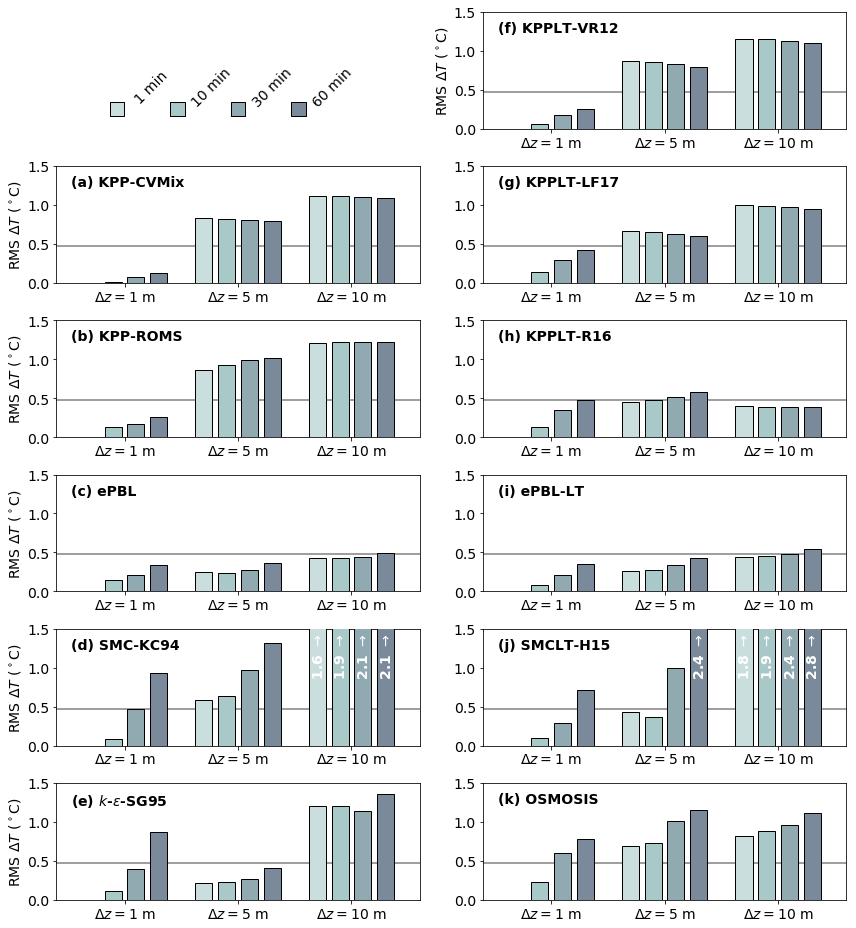

In [6]:
# plot figure
nrow = (nm+2)//2
fig_width = 12
fig_height = 3+2*(nrow-1)
height_ratios = [1]*nrow
height_ratios.append(0.15)
width_ratios = [1, 1, 0.05]
f, axarr = plt.subplots(nrow, 2)
f.set_size_inches(fig_width, fig_height)

# --------
# create legend
# --------
xx = np.arange(ndt)+1
yy = np.ones(xx.size)
axarr[0,0].spines['bottom'].set_color('white')
axarr[0,0].spines['top'].set_color('white') 
axarr[0,0].spines['right'].set_color('white')
axarr[0,0].spines['left'].set_color('white')
axarr[0,0].axes.get_yaxis().set_visible(False)
axarr[0,0].axes.get_xaxis().set_visible(False)
axarr[0,0].scatter(xx, yy, s=200, c=bcolor, marker='s', edgecolors='k', linewidths=1)
axarr[0,0].set_xlim(0, 6)
axarr[0,0].set_ylim(0.8, 2)
dt_str = [' 1 min', '10 min', '30 min', '60 min']
# axarr[0,0].text(xx[0], 1.5, '$\Delta t$', fontsize=16, fontweight='bold')
for i in np.arange(ndt):
    axarr[0,0].text(xx[i]+0.2, yy[i], dt_str[i], fontsize=14,
                    rotation=45, va='bottom', ha='left')

# --------
# panel a-k
# --------
xlabel_list = [r'$\Delta z=1$ m', r'$\Delta z=5$ m', r'$\Delta z=10$ m' ]
# loop over all turbulence methods
for i in np.arange(nm):
    # indices
    n = icol_2col[i]
    m = irow_2col[i]
    # rmse
    error_dzdt = rmse_all[i,:]
    # plot reference line
    axarr[m,n].axhline(y=mean_std, linewidth=1.5, color='gray')
    # plot bars
    xshift = (np.arange(ndt)-1.5)*0.2
    xx = np.arange(3)+1
    xx_bar = np.zeros(nzt)
    for k in np.arange(ndt):
        axarr[m,n].bar(xx+xshift[k], error_dzdt[k:9+k:4], width=0.15, bottom=None,
                       align='center', color=bcolor[k], edgecolor='black', zorder=5)
        xx_bar[k:9+k:4] = xx+xshift[k]
    # add label for those bars that go beyond the maximum y
    for k in np.arange(nzt):
        if error_dzdt[k] > ymax:
            var_str = '{:4.1f}'.format(error_dzdt[k])
            axarr[m,n].text(xx_bar[k]+0.01, ymax-0.05, var_str+r' $\rightarrow$',
                            color='white', fontsize=14, fontweight='bold',
                            rotation=90, va='top', ha='center', zorder=6)
    # set x- and y-axis labels
    if n == 0 or m == 0 and n == 1:
        axarr[m, n].set_ylabel('RMS $\Delta T$ ($^\circ$C)', fontsize=14)
    axarr[m, n].set_xlim(0.4,3.6)
    axarr[m, n].set_ylim(0, ymax)
    plt.setp(axarr[m,n], xticks=xx, xticklabels=xlabel_list)
    for tick in axarr[m,n].xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in axarr[m,n].yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    axarr[m, n].text(0.04, 0.92, labels_2col[i]+' '+legend_list[i],
                     transform=axarr[m, n].transAxes,
                     fontsize=14, fontweight='bold', va='top', zorder=7)
    
# reduce margin
plt.tight_layout()

# save figure
figname = figdir+'/fig_cmp_dzdt_'+var+'.png'
plt.savefig(figname, dpi = 300)
